# Coding Block 1 - Linear Regression

### Load the packages

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression

'''
...
'''

'\n...\n'

### Read the dataset

In [28]:
diab=pd.read_csv('diabetes.csv')

### Refresher: Some Basic Exploratory Data Analysis

Start with some basic EDA before doing predictive modeling

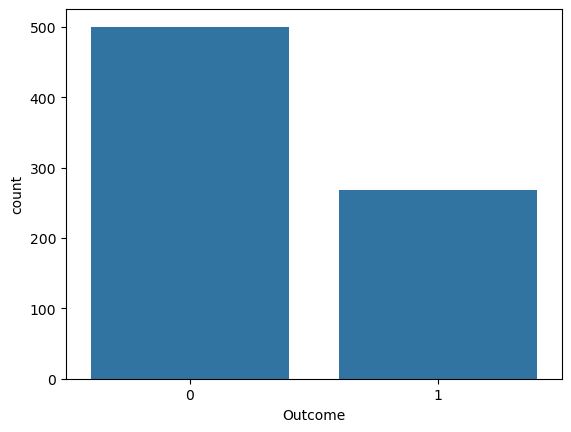

In [29]:
sns.countplot(x='Outcome',data=diab)
plt.show()

### Analysis Of Diabetic Cases

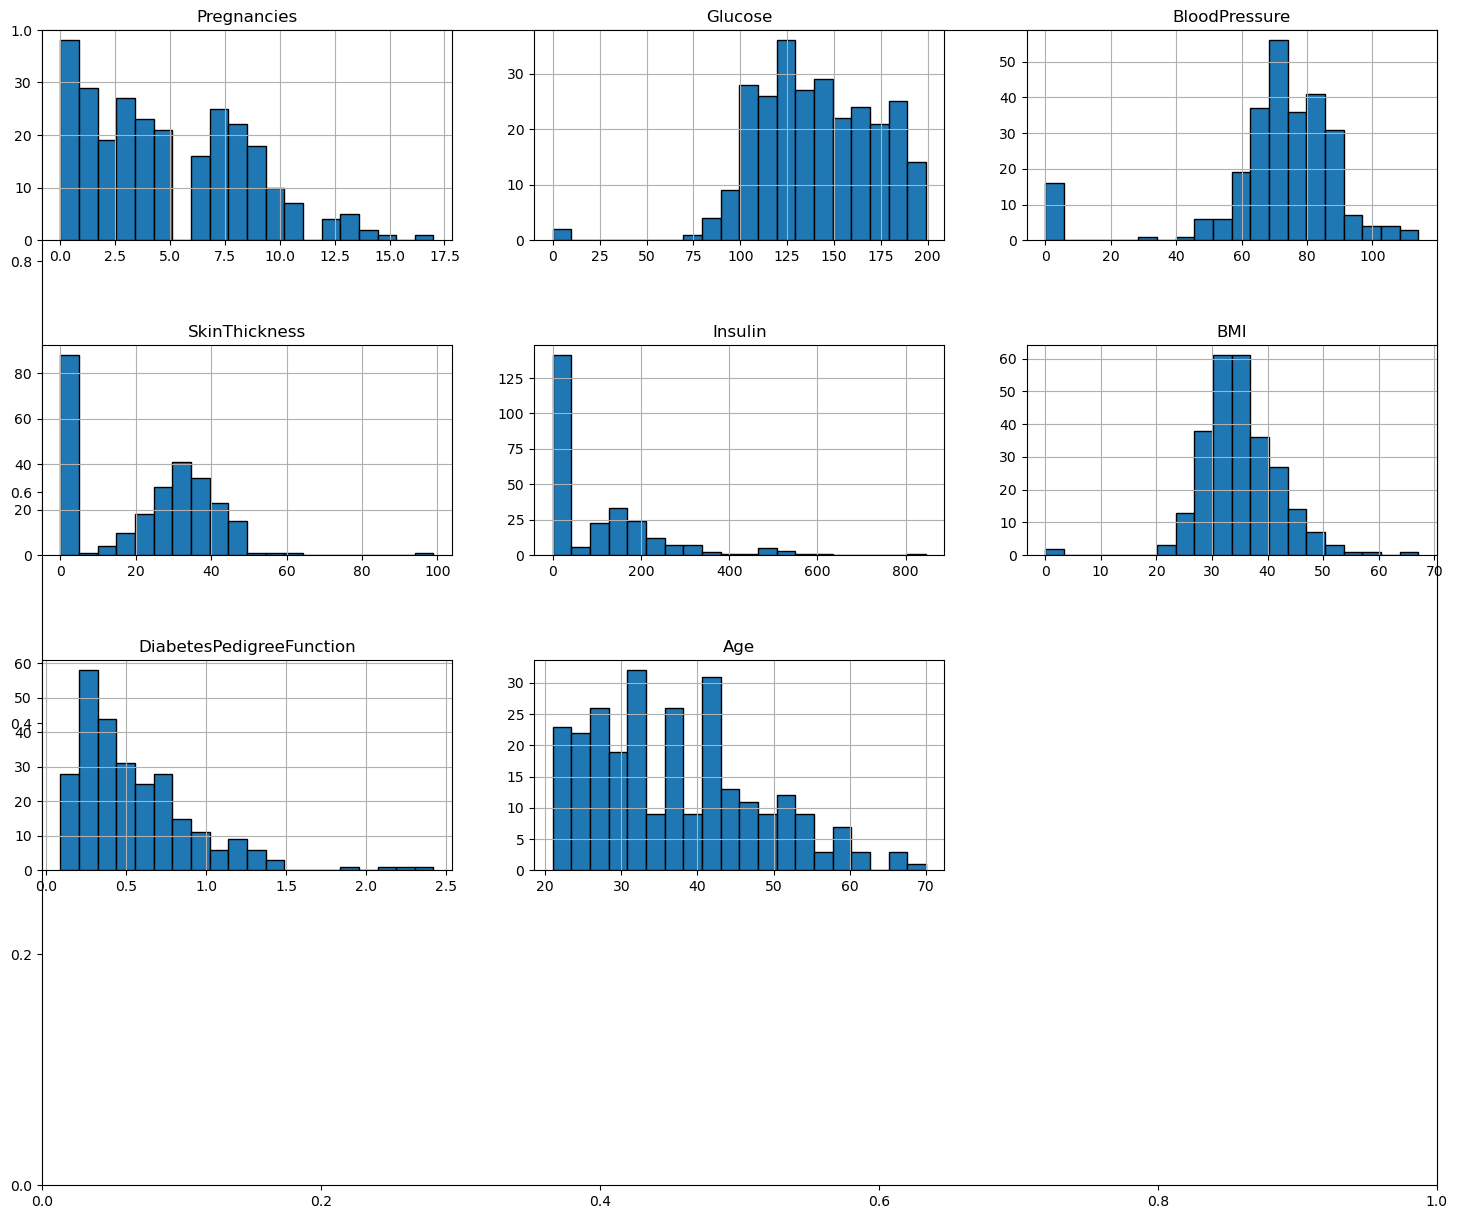

In [30]:
diab1=diab[diab['Outcome']==1]
columns=diab.columns[:8]
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(int((length/2)),3,int(j+1))
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    diab1[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

### PairPlots:

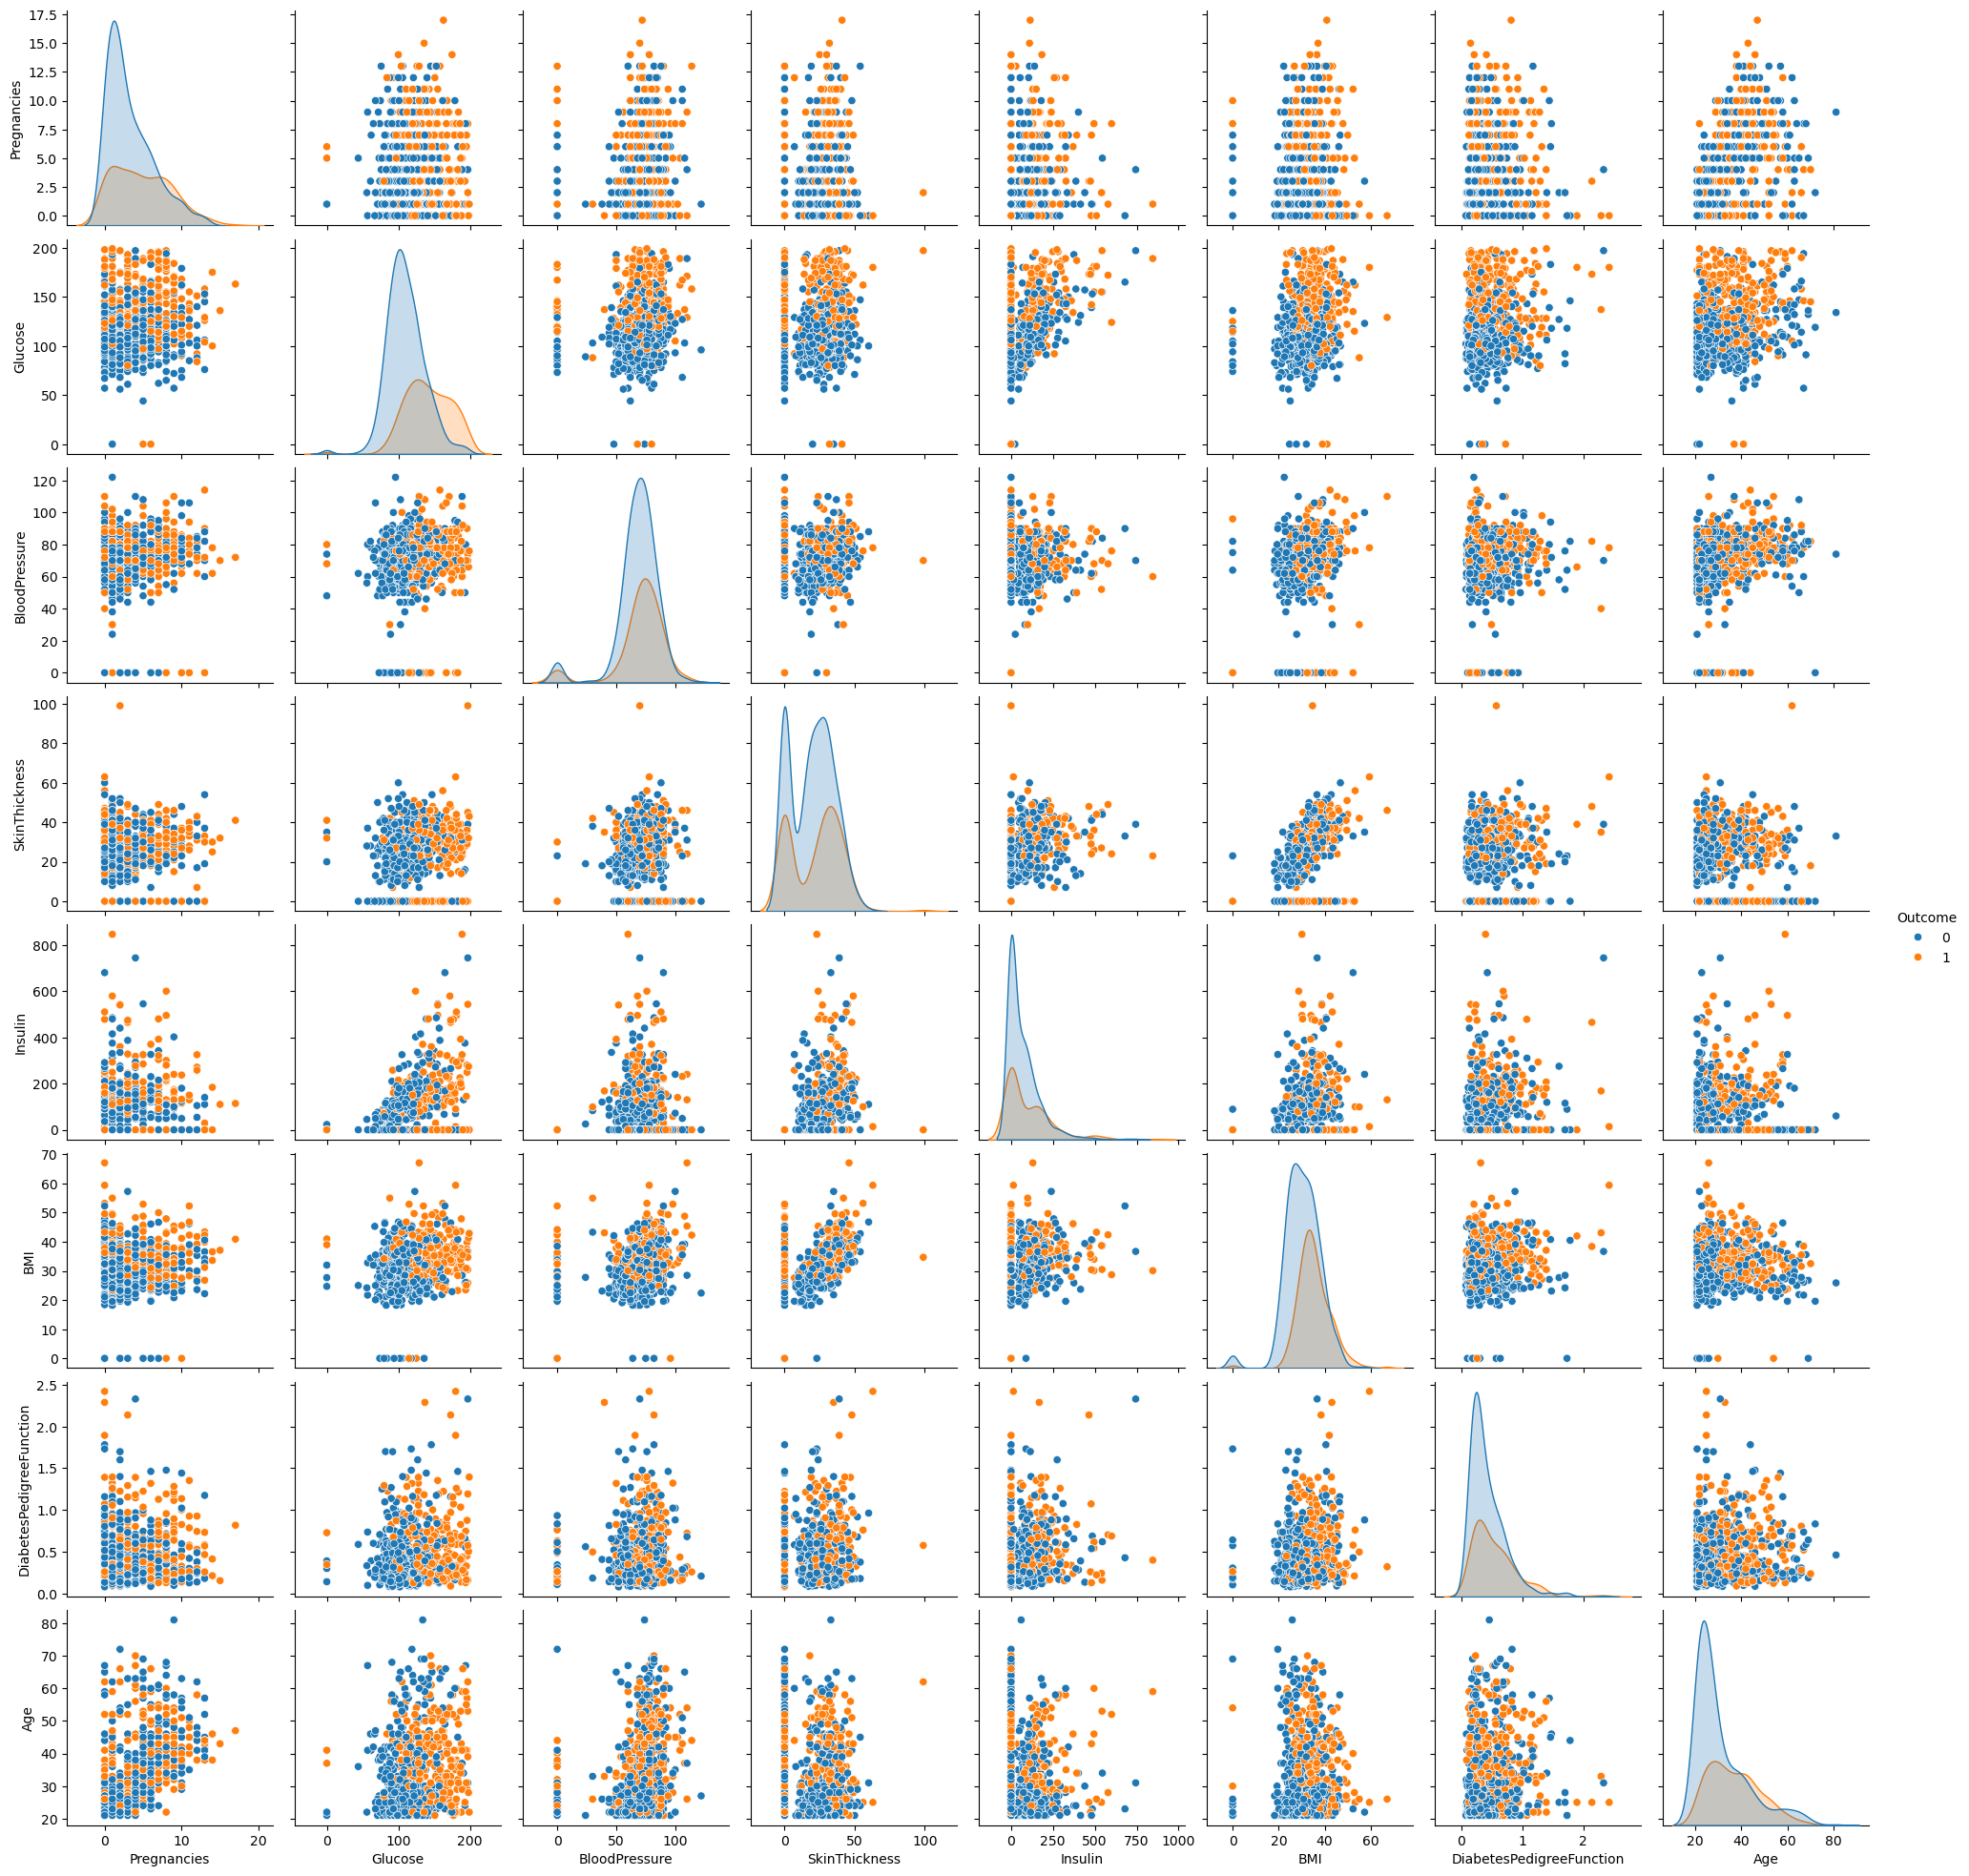

In [31]:
sns.pairplot(data=diab,hue='Outcome',diag_kind='kde')
plt.show()

The diagonal shows the distribution of the the dataset with the kernel density plots.

The scatter-plots shows the relation between each and every attribute or features taken pairwise. Are any two attributes able to clearly seperate the two outcome-class instances?

### Let's Do Some Predictive Modeling

### Do a Linear Regression to impute the missing data

In [32]:
# Identify columns where 0 represents missing values
missing_value_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]  # Example columns
# Replace 0 with NaN in specified columns
diab[missing_value_columns] = diab[missing_value_columns].replace(0, pd.NA)

In [33]:
# Hot-deck imputation: Replace NA by randomly sampling from the same column
diab_hotDeckImpute = diab.copy(deep=True)
for column in missing_value_columns:
    diab_hotDeckImpute[column] = diab_hotDeckImpute[column].apply(lambda x: np.random.choice(diab_hotDeckImpute[column].dropna()) if pd.isna(x) else x)


Imputing Glucose...
Imputed 5 missing values in Glucose

Imputing BloodPressure...
Imputed 35 missing values in BloodPressure

Imputing SkinThickness...
Imputed 227 missing values in SkinThickness

Imputing Insulin...
Imputed 374 missing values in Insulin

Imputing BMI...
Imputed 11 missing values in BMI


/tmp/ipykernel_739781/1559818832.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_missing[feat] = X_missing[feat].fillna(X_train[feat].median())
/tmp/ipykernel_739781/1559818832.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_missing[feat] = X_missing[feat].fillna(X_train[feat].median())
/tmp/ipykernel_739781/1559818832.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_

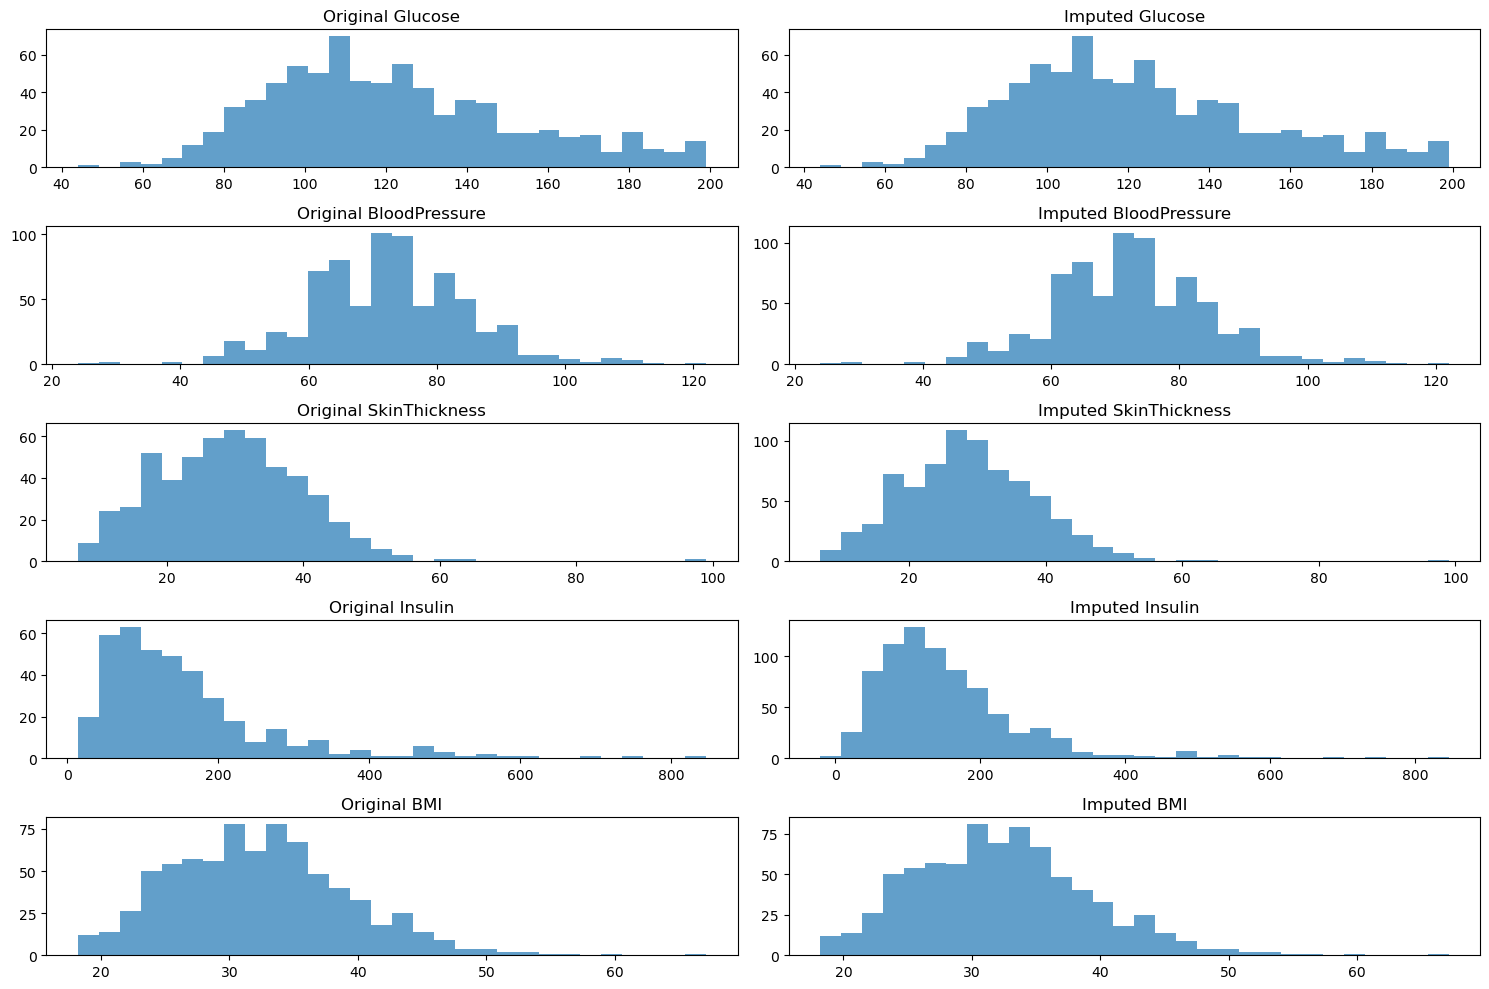


Original Data Statistics:
        Glucose  BloodPressure  SkinThickness  Insulin    BMI
count       763            733            541      394  757.0
unique      135             46             50      185  247.0
top          99             70             32      105   32.0
freq         17             57             31       11   13.0

Imputed Data Statistics:
        Glucose  BloodPressure  SkinThickness  Insulin    BMI
count       768            768            768      768  768.0
unique      140             81            277      559  258.0
top          99             70             32      105   32.0
freq         17             57             31       11   13.0

Missing values before imputation:
Glucose: 5 (NA values)
BloodPressure: 35 (NA values)
SkinThickness: 227 (NA values)
Insulin: 374 (NA values)
BMI: 11 (NA values)

Missing values after imputation:
Glucose: 0 (zero values)
BloodPressure: 0 (zero values)
SkinThickness: 0 (zero values)
Insulin: 0 (zero values)
BMI: 0 (zero valu

In [35]:
# Create a copy of the dataset for imputation
diab_imputed = diab.copy()

# Function to impute missing values using linear regression
def impute_with_linear_regression(df, column):
    # Check if column contains pd.NA values or zeros as missing values
    if df[column].isna().any():
        # For columns with pd.NA values
        train_data = df[~df[column].isna()].copy()
        missing_data = df[df[column].isna()].copy()
    else:
        # For columns with zeros as missing values
        train_data = df[df[column] != 0].copy()
        missing_data = df[df[column] == 0].copy()
    
    if missing_data.shape[0] == 0:
        print(f"No missing values in {column}")
        return df
    
    # Use all other columns as features, except the target and Outcome
    features = [f for f in df.columns if f != column and f != 'Outcome']
    
    # Remove rows with NA in features for training
    X_train = train_data[features].copy()
    y_train = train_data[column].copy()
    
    # Drop rows with NA in features for training
    valid_rows = ~X_train.isna().any(axis=1)
    X_train = X_train[valid_rows]
    y_train = y_train[valid_rows]
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_missing = missing_data[features].copy()
    
    # Handle missing values in prediction features by filling with median
    for feat in features:
        if X_missing[feat].isna().any():
            X_missing[feat] = X_missing[feat].fillna(X_train[feat].median())
    
    predicted_values = model.predict(X_missing)
    
    # Replace missing values in the original dataframe
    result_df = df.copy()
    if df[column].isna().any():
        # For columns with pd.NA values
        result_df.loc[df[column].isna(), column] = predicted_values
    else:
        # For columns with zeros as missing values
        result_df.loc[df[column] == 0, column] = predicted_values
    
    print(f"Imputed {missing_data.shape[0]} missing values in {column}")
    
    return result_df

# Impute missing values for each column
for column in missing_value_columns:
    print(f"\nImputing {column}...")
    diab_imputed = impute_with_linear_regression(diab_imputed, column)

# Compare original and imputed values
plt.figure(figsize=(15, 10))
for i, column in enumerate(missing_value_columns, 1):
    plt.subplot(len(missing_value_columns), 2, i*2-1)
    # Filter out zeros (as missing values) and NA values
    original_valid = diab[diab[column] != 0][column]
    original_valid = original_valid[~original_valid.isna()]
    plt.hist(original_valid, bins=30, alpha=0.7)
    plt.title(f"Original {column}")
    
    plt.subplot(len(missing_value_columns), 2, i*2)
    # Filter out any remaining zeros or NA values
    imputed_valid = diab_imputed[column][~diab_imputed[column].isna()]
    plt.hist(imputed_valid, bins=30, alpha=0.7)
    plt.title(f"Imputed {column}")

plt.tight_layout()
plt.show()

# Display statistics of original and imputed data
print("\nOriginal Data Statistics:")
print(diab[missing_value_columns].describe())

print("\nImputed Data Statistics:")
print(diab_imputed[missing_value_columns].describe())

# Count number of missing values before and after imputation
print("\nMissing values before imputation:")
for col in missing_value_columns:
    if diab[col].isna().any():
        print(f"{col}: {diab[col].isna().sum()} (NA values)")
    else:
        print(f"{col}: {(diab[col] == 0).sum()} (zero values)")

print("\nMissing values after imputation:")
for col in missing_value_columns:
    if diab_imputed[col].isna().any():
        print(f"{col}: {diab_imputed[col].isna().sum()} (NA values)")
    else:
        print(f"{col}: {(diab_imputed[col] == 0).sum()} (zero values)")

### Compare linear regression output for imputation with simpler imputation techniques from the previous days

Imputation Method Comparison Statistics:
               Mean Difference (HotDeck)  Mean Difference (Regression)  \
Glucose                              0.0                           0.0   
BloodPressure                        0.0                           0.0   
SkinThickness                        0.0                           0.0   
Insulin                              0.0                           0.0   
BMI                                  0.0                           0.0   

               Std Difference (HotDeck)  Std Difference (Regression)  
Glucose                             0.0                          0.0  
BloodPressure                       0.0                          0.0  
SkinThickness                       0.0                          0.0  
Insulin                             0.0                          0.0  
BMI                                 0.0                          0.0  


/tmp/ipykernel_739781/4203352509.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Original', 'Hot Deck', 'Regression'])
/tmp/ipykernel_739781/4203352509.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Original', 'Hot Deck', 'Regression'])
/tmp/ipykernel_739781/4203352509.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Original', 'Hot Deck', 'Regression'])
/tmp/ipykernel_739781/4203352509.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; s

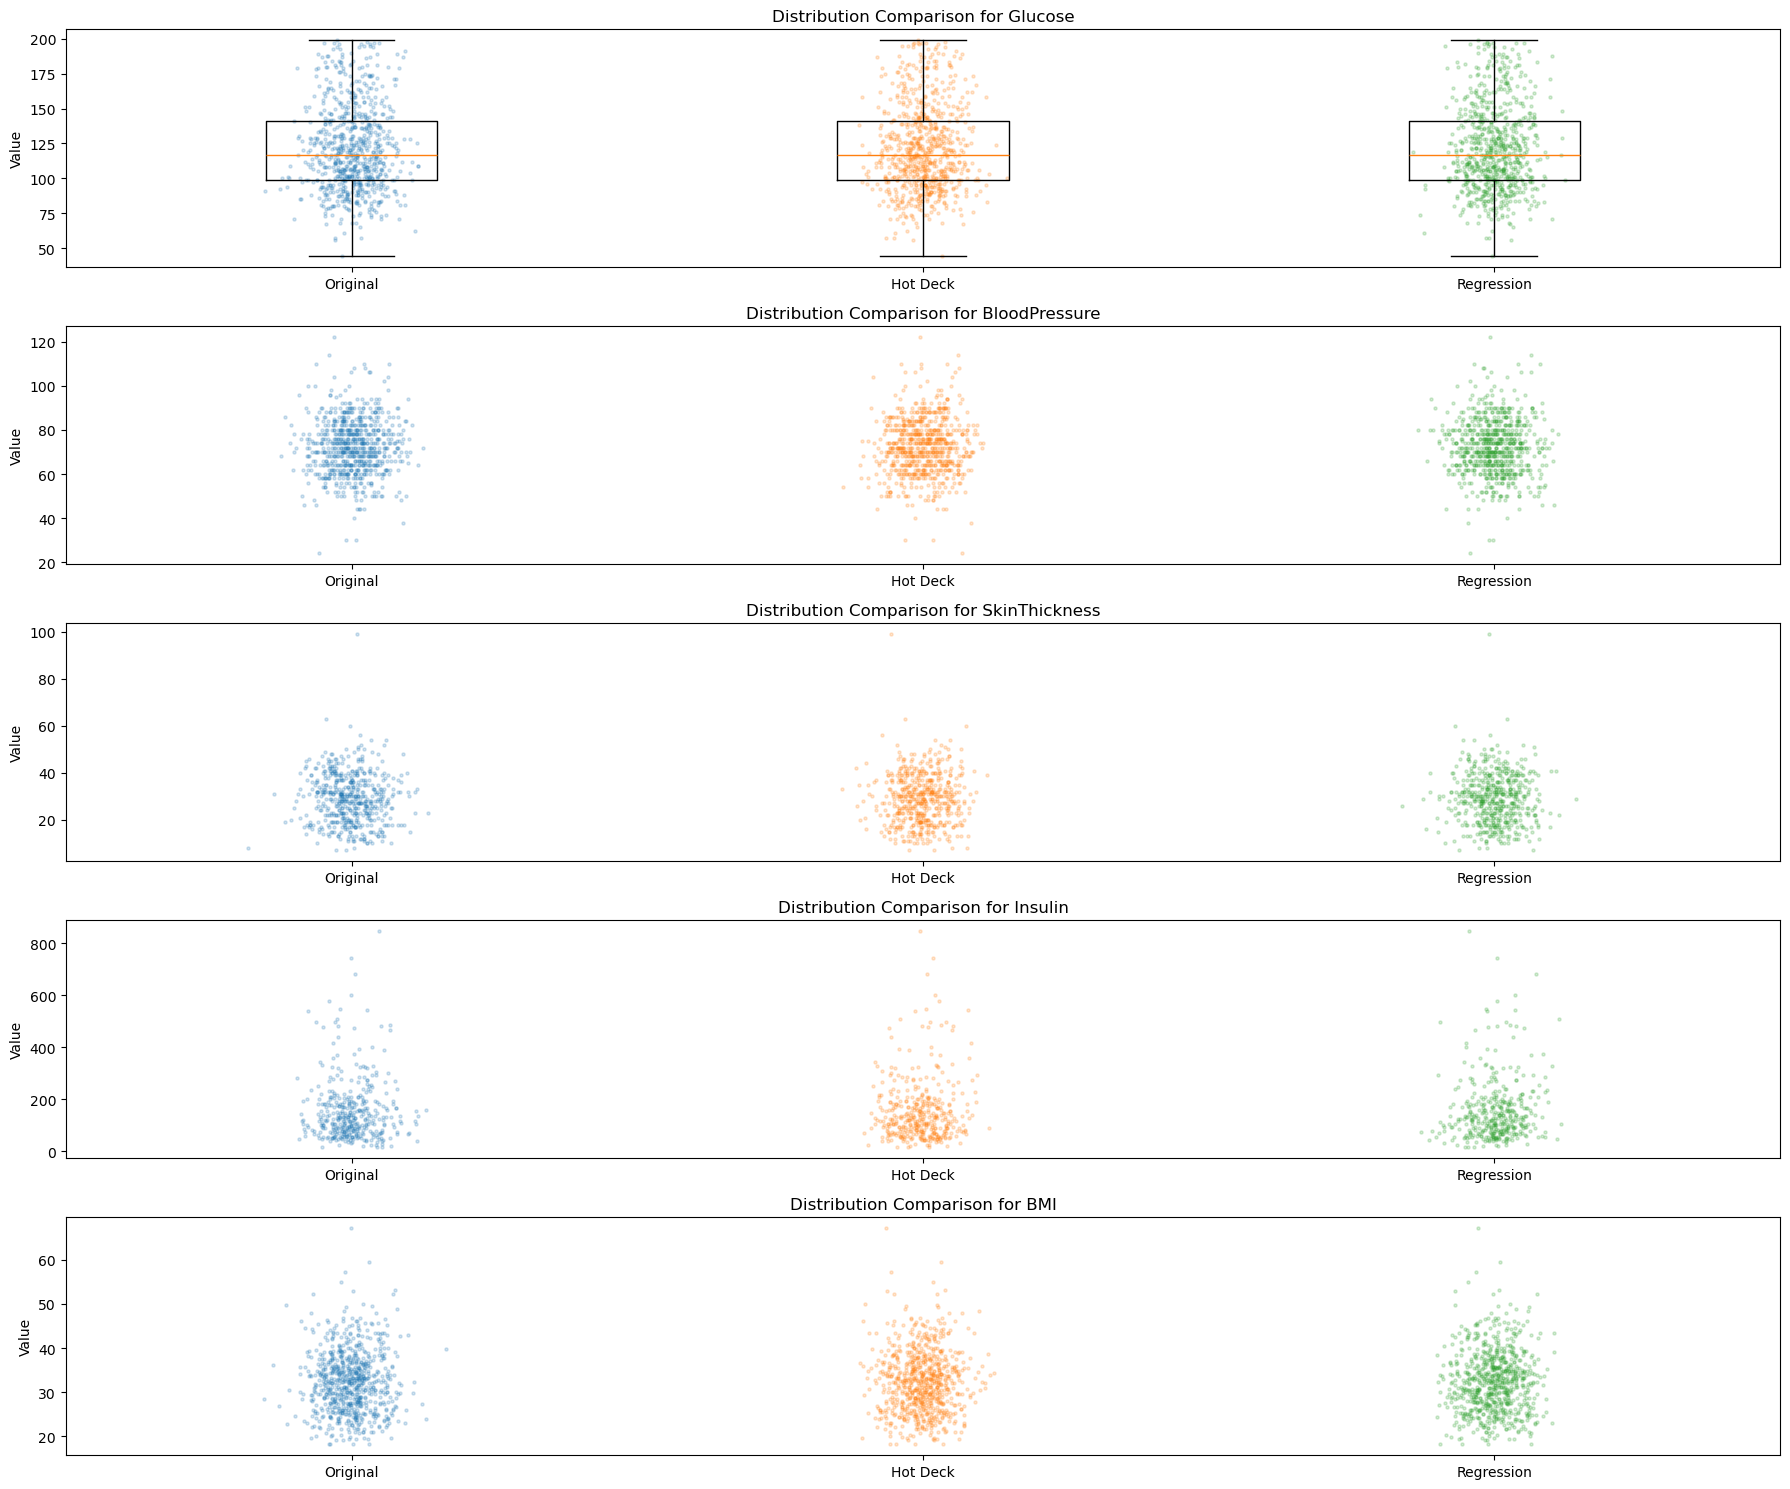

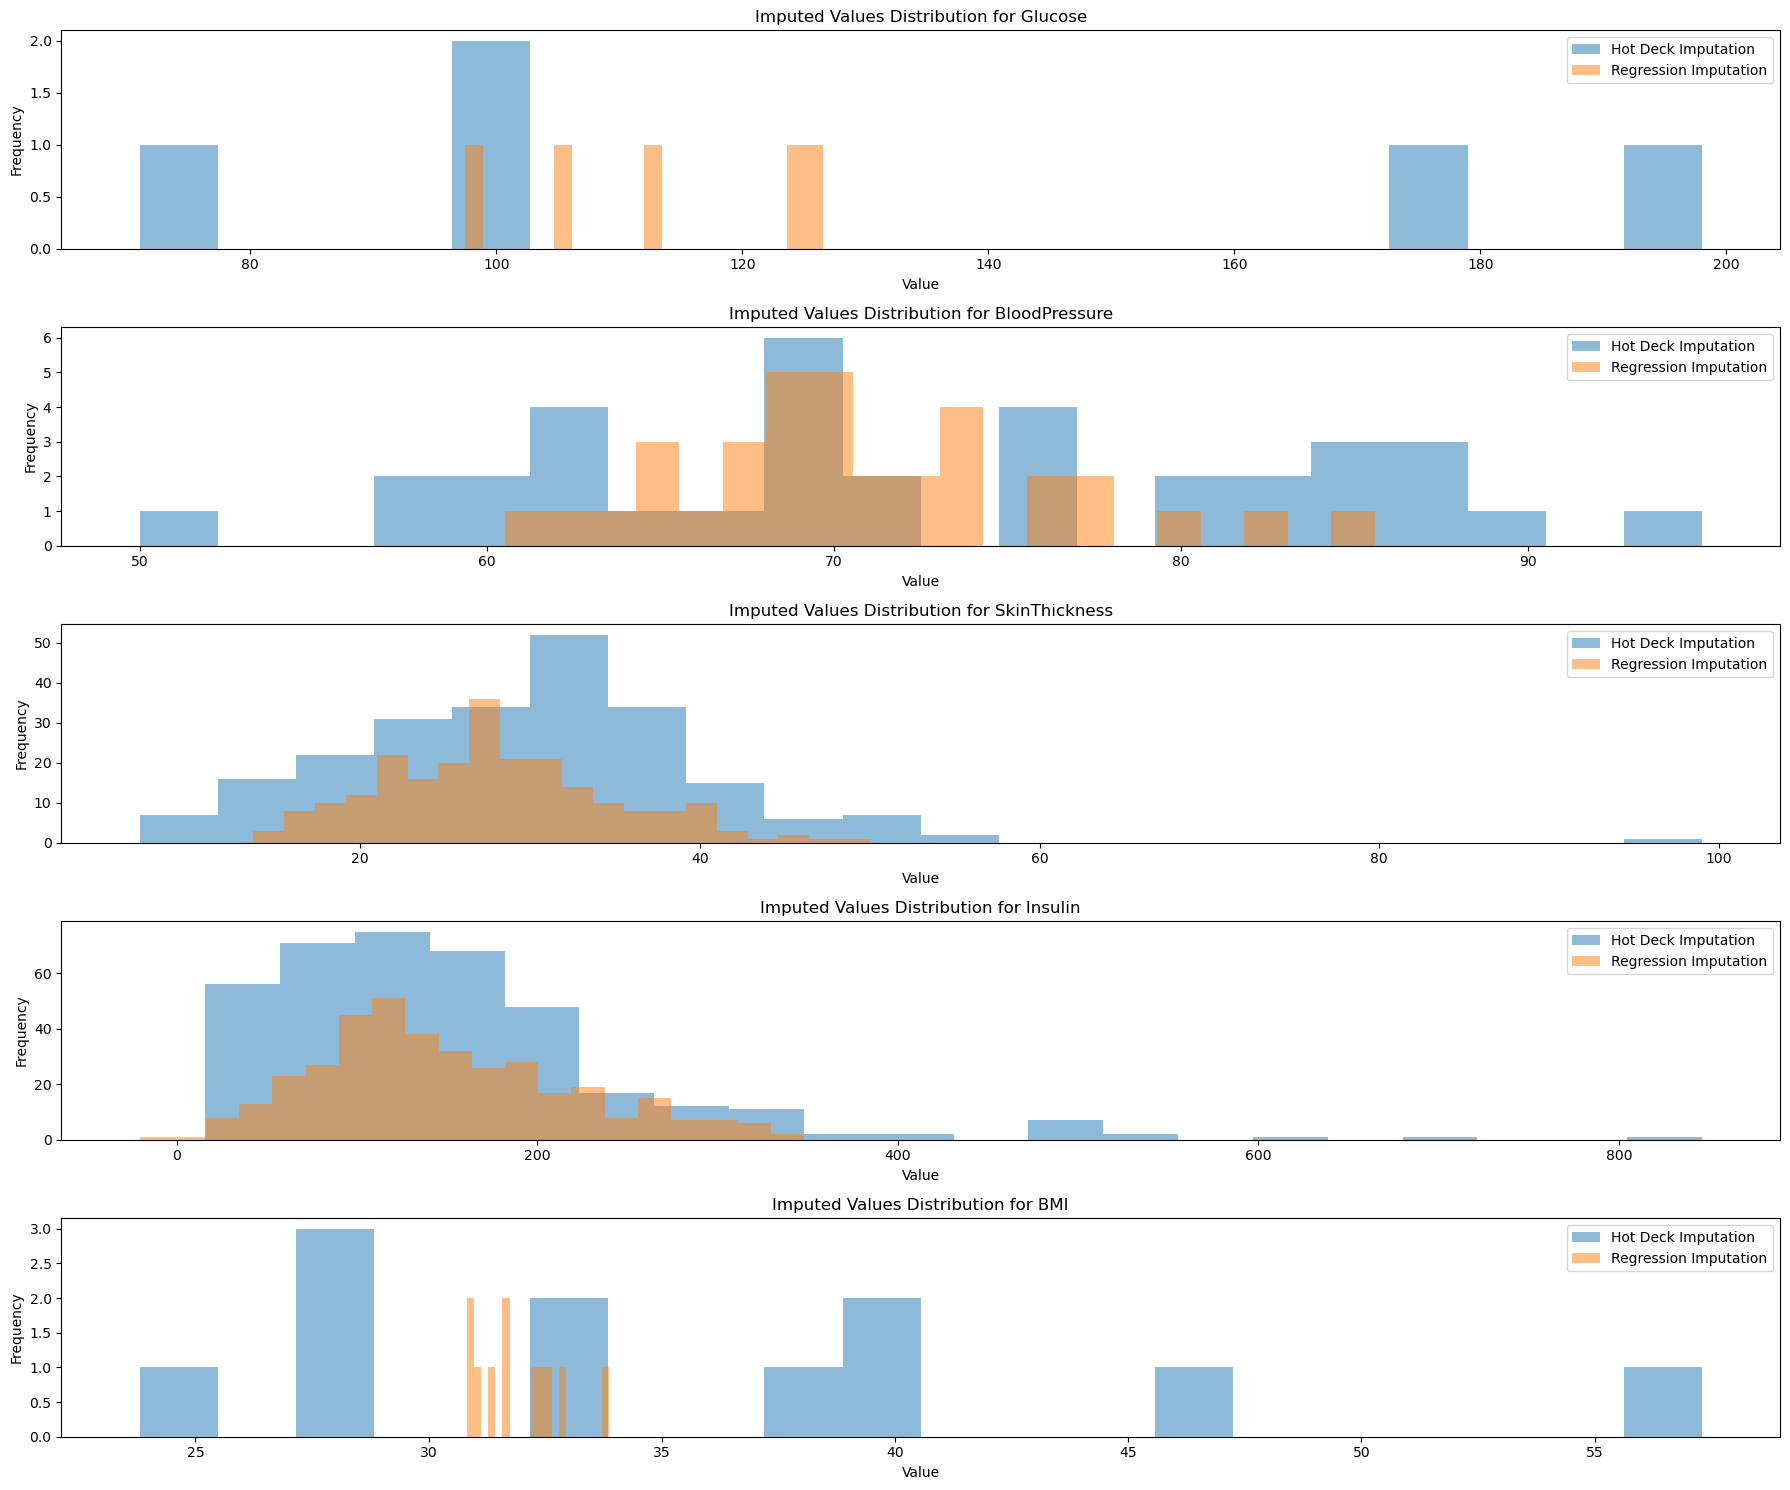

In [36]:
# Create a DataFrame to compare different imputation methods
comparison_df = pd.DataFrame()

# Original data where available (non-missing values)
for col in missing_value_columns:
    # Get the indices where the original values were not missing
    valid_indices = diab[col].notna()
    comparison_df[f'{col}_original'] = diab.loc[valid_indices, col]
    comparison_df[f'{col}_hotdeck'] = diab_hotDeckImpute.loc[valid_indices, col]
    comparison_df[f'{col}_regression'] = diab_imputed.loc[valid_indices, col]

# Calculate statistics for comparison
stats_comparison = {}
for col in missing_value_columns:
    stats_comparison[col] = {
        'Mean Difference (HotDeck)': pd.to_numeric(comparison_df[f'{col}_hotdeck'] - pd.to_numeric(comparison_df[f'{col}_original'])).mean(),
        'Mean Difference (Regression)': pd.to_numeric(comparison_df[f'{col}_regression'] - pd.to_numeric(comparison_df[f'{col}_original'])).mean(),
        'Std Difference (HotDeck)': pd.to_numeric(comparison_df[f'{col}_hotdeck'] - pd.to_numeric(comparison_df[f'{col}_original'])).std(),
        'Std Difference (Regression)': pd.to_numeric(comparison_df[f'{col}_regression'] - pd.to_numeric(comparison_df[f'{col}_original'])).std()
    }

# Display statistics
stats_df = pd.DataFrame(stats_comparison).T
print("Imputation Method Comparison Statistics:")
print(stats_df)

# Create plots to visualize the differences between original values and imputed values
plt.figure(figsize=(18, 15))
for i, col in enumerate(missing_value_columns, 1):
    plt.subplot(len(missing_value_columns), 1, i)
    
    # Convert to numeric to ensure proper comparison
    orig = pd.to_numeric(comparison_df[f'{col}_original'])
    hotdeck = pd.to_numeric(comparison_df[f'{col}_hotdeck'])
    regress = pd.to_numeric(comparison_df[f'{col}_regression'])
    
    # Create boxplots
    box_data = [orig, hotdeck, regress]
    plt.boxplot(box_data, labels=['Original', 'Hot Deck', 'Regression'])
    plt.title(f'Distribution Comparison for {col}')
    plt.ylabel('Value')
    
    # Add some jittered points for better visualization
    for j, data in enumerate([orig, hotdeck, regress]):
        x = np.random.normal(j+1, 0.04, size=len(data))
        plt.scatter(x, data, alpha=0.2, s=5)

plt.tight_layout()
plt.show()

# Distribution plots for imputed values (for missing values only)
plt.figure(figsize=(18, 15))
for i, col in enumerate(missing_value_columns, 1):
    plt.subplot(len(missing_value_columns), 1, i)
    
    # Get indices where original values were missing
    missing_indices = diab[col].isna()
    
    # Extract imputed values only where original was missing
    hotdeck_imputed = pd.to_numeric(diab_hotDeckImpute.loc[missing_indices, col])
    regression_imputed = pd.to_numeric(diab_imputed.loc[missing_indices, col])
    
    # Plot histograms
    plt.hist(hotdeck_imputed, bins=20, alpha=0.5, label='Hot Deck Imputation')
    plt.hist(regression_imputed, bins=20, alpha=0.5, label='Regression Imputation')
    plt.title(f'Imputed Values Distribution for {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()